In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopy
from geopy import distance
from geopy.distance import vincenty
# from tqdm import tqdm
# tqdm.pandas()
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
import numpy as np

import eli5
from eli5.sklearn import PermutationImportance
# from skopt.space import Real
import matplotlib.colors as clt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Using TensorFlow backend.
C:\Users\lorie\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\lorie\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
train = pd.read_csv('listings.csv.gz', compression='gzip')
price_df = pd.read_csv('listings.csv')


In [3]:
# train.head()

In [4]:

lon = -90.0680352
lat = 29.9585246
train['distance_center'] = train.apply(lambda x: vincenty((x['latitude'], x['longitude']), (lat, lon)).miles, axis = 1)




In [5]:
train['price']=(train['price'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['cleaning_fee']=(train['cleaning_fee'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['security_deposit']=(train['security_deposit'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
sample = train.sample(1000, random_state=42)
bins= [0,50,100,150,200,250,300,350,400,450,500,10000]
labels = ['$50','$100','$150','$200','$250','$300','$350','$400','$450','$500', '$10000']
# sample['price'] = pd.cut(sample['price'], bins=bins, labels=labels)
train['price'].head()


0    300.0
1    100.0
2    125.0
3    115.0
4     50.0
Name: price, dtype: float64

In [6]:
train.head()
cleanmean=train['cleaning_fee'].dropna().mean()
train['cleaning_fee']=train['cleaning_fee'].fillna(cleanmean)
train['square_feet']=train['square_feet'].fillna(train['square_feet'].dropna().mean())
train['price']=train['price'].fillna(train['price'].dropna().mean())
train['bathrooms']=train['bathrooms'].fillna(train['bathrooms'].dropna().mean())
train['bedrooms']=train['bedrooms'].fillna(train['bedrooms'].dropna().mean())
train['beds']=train['beds'].fillna(train['beds'].dropna().mean())
train['square_feet']=train['square_feet'].fillna(train['square_feet'].dropna().mean())
train['security_deposit']=train['security_deposit'].fillna(train['security_deposit'].dropna().mean())

In [7]:
train['price'].max()

8000.0

In [8]:
df = train.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review', 'reviews_per_month'])
label_encoder=LabelEncoder()
label_encoder.fit(df['neighbourhood_cleansed'])
df['neighbourhood_cleansed']=label_encoder.transform(df['neighbourhood_cleansed'])
# label_encoder.fit(df['price'])
# df['price']=label_encoder.transform(df['price'])

label_encoder.fit(df['square_feet'])
df['square_feet']=label_encoder.transform(df['square_feet'])
label_encoder.fit(df['property_type'])
df['property_type']=label_encoder.transform(df['property_type'])
label_encoder.fit(df['room_type'])
df['room_type']=label_encoder.transform(df['room_type'])
label_encoder.fit(df['distance_center'])
df['distance_center']=label_encoder.transform(df['distance_center'])
label_encoder.fit(df['cleaning_fee'])
df['cleaning_fee']=label_encoder.transform(df['cleaning_fee'])
label_encoder.fit(df['bathrooms'])
df['bathrooms']=label_encoder.transform(df['bathrooms'])
label_encoder.fit(df['bedrooms'])
df['bedrooms']=label_encoder.transform(df['bedrooms'])
label_encoder.fit(df['beds'])
df['beds']=label_encoder.transform(df['beds'])
label_encoder.fit(df['host_listings_count'])
df['host_listings_count']=label_encoder.transform(df['host_listings_count'])
label_encoder.fit(df['security_deposit'])
df['security_deposit']=label_encoder.transform(df['security_deposit'])
label_encoder.fit(df['guests_included'])
df['guests_included']=label_encoder.transform(df['guests_included'])
label_encoder.fit(df['number_of_reviews'])
df['number_of_reviews']=label_encoder.transform(df['number_of_reviews'])

In [9]:
df['price'].max()

8000.0

In [10]:

# bins1 = [48,100, 150, 250,300,350]
# labels1 = [1,2,3,4, 5]
# # train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1).astype('int')
# df['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)

In [11]:
test = pd.DataFrame({
    'Hood': df['neighbourhood_cleansed'],
    'SqFt':df['square_feet'],
    '#Reviews':df['number_of_reviews'],
    '#Guests':df['guests_included'],
    'Listing Count':df['host_listings_count'],
    'Security':df['security_deposit'],
    'CleanFee':df['cleaning_fee'],
    'Dist':df['distance_center'],
#     'Room':df['room_type'],
    'BA':df['bathrooms'], 
#     'Prop':df['property_type'],
    'BR':df['bedrooms'], 
    'Beds': df['beds'],
    'Acc':df['accommodates'],
    'Price':df['price']
})

# train1 = train.dropna()
test.to_csv('test1_data.csv')
# train1['Hood'].unique

In [12]:
df1 = df.groupby(['neighbourhood_cleansed']).mean()
price_grouped = price_df.groupby(['neighbourhood']).mean()
price = price_grouped['price']
# df.head()
df1.head()

,host_acceptance_rate,host_listings_count,host_total_listings_count,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,distance_center
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,2.622951,7.606557,12.803279,0.114754,4.262295,2.213115,2.540984,3.065574,19.950820,140.786885,15.163934,55.245902,1.540984,2.147541,612.426230,2.016393,2.409836,612.426230,612.426230,2.178689,612.426230,6.540984,17.836066,35.147541,173.114754,50.180328,23.426230,97.754386,9.877193,9.842105,9.982456,9.912281,9.824561,9.859649,2.491803,2.344262,0.147541,0.0,2149.278689
1,NaN,2.540984,5.032787,13.286885,0.180328,4.770492,2.663934,2.598361,3.147541,19.868852,240.122951,18.319672,60.778689,1.786885,3.745902,610.745902,3.713115,4.040984,610.745902,610.745902,3.770492,610.745902,9.524590,22.803279,41.663934,155.598361,37.631148,17.918033,97.214286,9.883929,9.758929,9.982143,9.964286,9.919643,9.732143,2.254098,1.836066,0.418033,0.0,5931.852459
2,NaN,2.825758,5.128788,12.992424,0.098485,4.280303,2.090909,2.348485,2.742424,20.068182,182.477273,16.916667,53.143939,1.151515,3.159091,666.537879,2.893939,3.681818,637.446970,655.022727,3.228030,637.772727,7.446970,18.204545,36.886364,139.772727,36.719697,14.628788,97.904000,9.928000,9.856000,9.976000,9.984000,9.736000,9.864000,2.621212,2.416667,0.204545,0.0,2986.962121
3,NaN,1.166667,1.166667,19.750000,0.083333,4.666667,2.166667,2.833333,2.916667,20.000000,122.750000,9.250000,52.750000,1.166667,1.916667,541.166667,1.916667,2.083333,541.166667,541.166667,1.975000,541.166667,9.916667,28.333333,52.583333,185.583333,15.166667,10.000000,94.888889,9.666667,9.555556,10.000000,10.000000,9.555556,9.777778,1.166667,1.083333,0.083333,0.0,5211.416667
4,NaN,3.655172,14.137931,14.448276,0.275862,3.655172,1.793103,2.241379,2.344828,20.000000,147.862069,13.793103,50.103448,1.206897,4.068966,571.413793,4.034483,4.275862,571.413793,571.413793,4.086207,571.413793,6.862069,17.344828,32.586207,145.551724,45.724138,18.413793,96.923077,9.923077,9.769231,10.000000,9.884615,9.846154,9.730769,3.206897,2.827586,0.379310,0.0,6301.448276


In [13]:
df1['price'].head()
# price.head()

neighbourhood_cleansed
0    140.786885
1    240.122951
2    182.477273
3    122.750000
4    147.862069
Name: price, dtype: float64

In [14]:
price_high = df1.loc[(df1['price']>=225)]
price_mid = df1[(df1['price']>150) & (df1['price'] <225)]
price_low = df1[(df1['price']>=0) & (df1['price'] <150)]
price_all = df1[df1['price']>1]
p_low = price_low.reset_index()
p_mid = price_mid.reset_index()
p_high = price_high.reset_index()
p_all = price_all.reset_index()

In [15]:
def bar_price(feature, index):
    fig, ax = plt.subplots()
    x_axis = np.arange(len(feature['price']))
    ax.bar(x_axis, feature['price'])
    labels =index['neighbourhood_cleansed']
    ax.set_xticks(x_axis)
    ax.set_xticklabels(labels, rotation=90, ha="right")

In [16]:

# bar_price(price_all, p_all)
# bar_price(price_low, p_low)
# bar_price(price_mid, p_mid)
# bar_price(price_high, p_high)

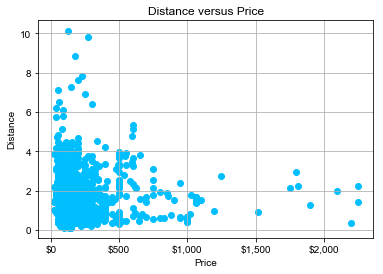

In [17]:
a = "#000080"
b = "#00BFFF"
c = "#32cd32"
d = "#FF4500"
clt.to_hex(a)
clt.to_hex(b)
clt.to_hex(c)
clt.to_hex(d)

price = sample['price']
dist = sample['distance_center']
fig, ax = plt.subplots()
ax.scatter(price,dist, color=b)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))


plt.style.use('seaborn')
plt.title('Distance versus Price')
plt.xlabel('Price')
plt.ylabel('Distance')
plt.grid()

plt.show()

In [18]:
# df = df.replace([np.inf, -np.inf], np.nan)
df = df.reset_index()
df.columns

Index(['index', 'space', 'description', 'experiences_offered', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_a

In [19]:
df['price'].min()

15.0

In [20]:

# df = df.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review', 'reviews_per_month'])


train1 = pd.DataFrame({
    'Hood': df['neighbourhood_cleansed'],
    'SqFt':df['square_feet'],
    '#Reviews':df['number_of_reviews'],
    '#Guests':df['guests_included'],
    'Listing Count':df['host_listings_count'],
    'Security':df['security_deposit'],
    'CleanFee':df['cleaning_fee'],
    'Dist':df['distance_center'],
#     'Room':df['room_type'],
    'BA':df['bathrooms'], 
#     'Prop':df['property_type'],
    'BR':df['bedrooms'], 
    'Beds': df['beds'],
    'Acc':df['accommodates'],
    'Price':df['price']
})
# train1=train1[:-1]
# train1['Price']

In [21]:
bins=[0,25,50,100,150,200]
labels=[1,2,3,4,5]
train1['CleanFee'] = pd.cut(train1['CleanFee'], bins=bins, labels=labels)
bins2=[0,1000,2000,3000,4000,5000,6000]
labels2=[.5,1,1.5,2,2.5,3]
train1['Dist'] = pd.cut(train1['Dist'], bins=bins2, labels=labels2)

bins1 = [0,50,100, 150, 250,300,400, 600, 1000, 8000]
labels1 = [1,2,3,4, 5, 6,7, 8, 9]
# train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1).astype('int')
train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)
train1['Dist']=train1['Dist'].fillna(2)
train1['CleanFee']=train1['CleanFee'].fillna(2)
train1.to_csv('test_data.csv')
# train1['Hood'].unique

In [22]:


from sklearn.preprocessing import StandardScaler

x = train1.drop('Price', axis=1)
y = train1['Price']
print(x.shape, y.shape)
x.isna().sum()

(6632, 12) (6632,)


Hood             0
SqFt             0
#Reviews         0
#Guests          0
Listing Count    0
Security         0
CleanFee         0
Dist             0
BA               0
BR               0
Beds             0
Acc              0
dtype: int64

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, stratify=y)

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)
# y_scaler = StandardScaler()
# encoded_y_train = (y_train)
# encoded_y_test = (y_test)


# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)
print(x_train_scaled.shape, y_train_categorical.shape)
print(x_test_scaled.shape, y_test_categorical.shape)


(3316, 12) (3316, 9)
(3316, 12) (3316, 9)


In [24]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

In [25]:
clf = KNeighborsClassifier(n_neighbors = 5)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.38963092187755544


In [26]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.4270173453996984


In [27]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.48884360973304986


In [28]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.20445628668520235


In [29]:
# clf = SVC()
# scoring = 'accuracy'
# score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

# print(score.mean())

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create model and add layers
model = Sequential()
model.add(Dense(units=100, activation='relu',input_dim=x_train_scaled.shape[1]))
# model.add(Dense(units=1000, activation='softmax'))
model.add(Dense(units=100, activation='relu'))

model.add(Dense(units=y_train_categorical.shape[1], activation='softmax'))
# model.add(Flatten())
# model.add(Dense(units=2, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1300      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 12,309
Trainable params: 12,309
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(
#                 optimizer='adam',
                optimizer='adadelta',
#               loss='categorical_crossentropy',
              loss='mse',
#                  metrics=['mean_squared_error', 'mean_absolute_error'])
              metrics=['accuracy'])
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])


In [32]:
model.fit(
    x_train_scaled,
    y_train_categorical,
    epochs=100,
    batch_size=10,
    shuffle=True,
    verbose=2
)



Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 1s - loss: 0.0843 - acc: 0.3779
Epoch 2/100
 - 0s - loss: 0.0794 - acc: 0.4168
Epoch 3/100
 - 0s - loss: 0.0778 - acc: 0.4291
Epoch 4/100
 - 0s - loss: 0.0768 - acc: 0.4388
Epoch 5/100
 - 1s - loss: 0.0760 - acc: 0.4524
Epoch 6/100
 - 0s - loss: 0.0751 - acc: 0.4575
Epoch 7/100
 - 0s - loss: 0.0742 - acc: 0.4741
Epoch 8/100
 - 0s - loss: 0.0737 - acc: 0.4759
Epoch 9/100
 - 0s - loss: 0.0729 - acc: 0.4822
Epoch 10/100
 - 0s - loss: 0.0724 - acc: 0.4925
Epoch 11/100
 - 0s - loss: 0.0718 - acc: 0.4925
Epoch 12/100
 - 0s - loss: 0.0713 - acc: 0.4940
Epoch 13/100
 - 0s - loss: 0.0707 - acc: 0.5075
Epoch 14/100
 - 0s - loss: 0.0702 - acc: 0.5163
Epoch 15/100
 - 1s - loss: 0.0700 - acc: 0.5060
Epoch 16/100
 - 0s - loss: 0.0693 - acc: 0.5181
Epoch 17/100
 - 0s - loss: 0.0690 - acc: 0.5217
Epoch 18/100
 - 0s - loss: 0.0685 - acc: 0.5238
Epoch 19/100
 - 0s - loss: 0.0681 - acc: 0.5314
Epoch 20/100
 - 0s - loss: 0.0678 - acc: 0.5338
E

In [33]:

model.evaluate(x_test_scaled, y_test_categorical, verbose=2)

[0.08761016922060341, 0.430940892641737]

In [34]:
model.evaluate(x_train_scaled, y_train_categorical, verbose=2)

[0.04084244935769943, 0.7539203860791371]

In [35]:
encoded_predictions = model.predict_classes(x_test_scaled[:5])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:5])}")


Predicted classes: [4 4 3 4 4]
Actual Labels: [3, 2, 2, 2, 9]


In [36]:
model.save("airbnb.h5")

In [37]:
from keras.models import load_model
model1=load_model("airbnb.h5")
testing = pd.read_csv('test_data.csv')
testing.head()

,Unnamed: 0,Hood,SqFt,#Reviews,#Guests,Listing Count,Security,CleanFee,Dist,BA,BR,Beds,Acc,Price
0,0,43,20,96,3,1,0,3,3.0,4,4,4,4,5
1,1,33,15,288,1,1,0,2,3.0,1,1,1,3,2
2,2,37,20,215,1,2,18,3,1.0,1,1,1,2,3
3,3,54,20,133,1,2,0,2,2.0,4,1,1,2,3
4,4,6,20,179,1,2,15,2,2.5,1,1,1,2,1


In [38]:
test_data=testing.drop('Unnamed: 0', axis=1)
price=test_data['Price']
test_data=test_data.drop('Price', axis=1)

x_scaler=StandardScaler().fit(test_data)
x_test_scaled1 = x_scaler.transform(test_data)
prediction=model1.predict_classes(x_test_scaled1)

label_encoder = LabelEncoder()
label_encoder.fit(price)
y_test1 = label_encoder.fit_transform(price)


In [39]:
# test_data.head()
submission = pd.DataFrame({"Prediction":prediction, "Price":y_test1})
submission.head()

,Prediction,Price
0,2,4
1,1,1
2,2,2
3,1,2
4,2,0


In [40]:
regr = GradientBoostingRegressor(n_estimators=75, learning_rate=0.17, max_depth=5, subsample=1.0,
                                 random_state=42)
regr.fit(x_train, y_train)
print(r2_score(y_test, regr.predict(x_test)))

0.6708845148384985


In [41]:
perm = PermutationImportance(regr, random_state=42).fit(x_test, y_test)
eli5.show_weights(perm, top=x.shape[1], feature_names = x.columns.tolist())

Weight,Feature
0.2404 ± 0.0125,Listing Count
0.1297 ± 0.0086,BA
0.0985 ± 0.0064,BR
0.0684 ± 0.0056,CleanFee
0.0611 ± 0.0100,Dist
0.0552 ± 0.0147,#Reviews
0.0526 ± 0.0079,Security
0.0329 ± 0.0054,Beds
0.0270 ± 0.0058,Acc
0.0268 ± 0.0056,Hood


In [42]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
print(f"Training Data Score: {classifier.score(x_train, y_train)}")
print(f"Testing Data Score: {classifier.score(x_test, y_test)}")

Training Data Score: 0.41676718938480095
Testing Data Score: 0.4028950542822678


In [44]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, x_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.4387698831580097


In [45]:
clf.fit(x_train,y_train)
prediction=clf.predict(test_data)
submission = pd.DataFrame({"Prediction":prediction, "Price":price})
submission.head(20)

,Prediction,Price
0,5,5
1,2,2
2,3,3
3,1,3
4,1,1
5,2,3
6,3,3
7,2,3
8,2,2
9,2,2
